In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import matplotlib.ticker as mtick

In [3]:
from sluis_hevelend import SluisHevelend

# Hevelend

In [4]:
alpha = 1
A = 7  # Doorstroomoppervlakte x coef van nivelleer mechaniek
A_hevelen = 2.5  # Doorstroomoppervlakte x coef van hevelende mechaniek
O_A = 2500
H = 10.85
T_l = 120
T_l_hevelen = 300

In [5]:
S = SluisHevelend(A_hevelen=A_hevelen, A=A, H=H, O_A=O_A, alpha=1, T_l=T_l, T_l_hevelen=T_l_hevelen)

Text(0.5, 1.0, 'Effect van maar deel van mogelijke hoogte hevelend schutten')

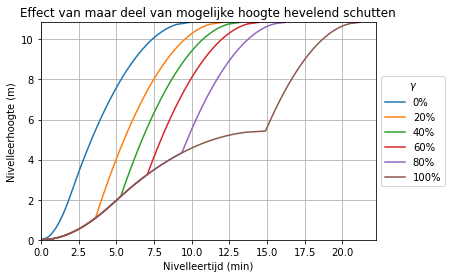

In [6]:
for aandeel_hevelend in np.linspace(0, 1, 6):
    S.gamma = aandeel_hevelend
    z, t = S.tijdserie()

    plt.plot(t / 60, z, label=f'{aandeel_hevelend:.0%}')
    
plt.grid()
plt.xlabel('Nivelleertijd (min)')
plt.ylabel('Nivelleerhoogte (m)')

plt.xlim(0, )
plt.ylim(0, H)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='$\gamma$')
plt.title('Effect van maar deel van mogelijke hoogte hevelend schutten')

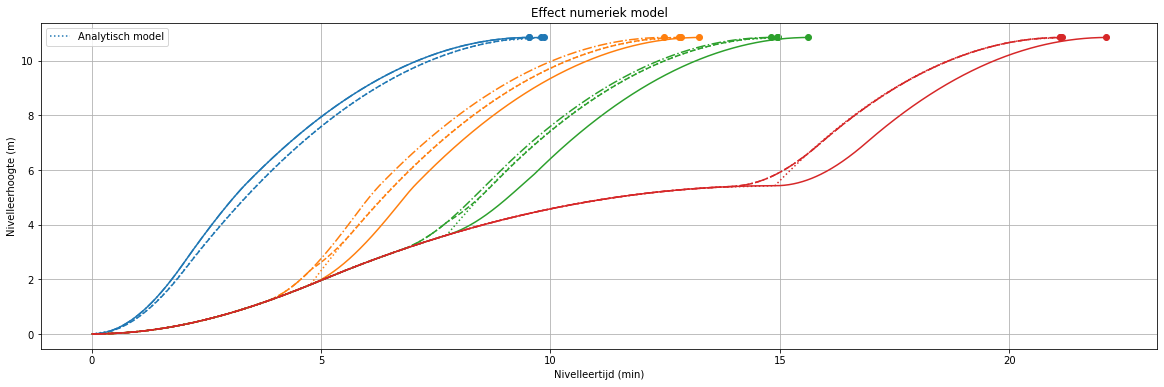

In [7]:
plt.subplots(figsize=(20, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + plt.rcParams['axes.prop_cycle'].by_key()['color']

for ii, aandeel_hevelend in enumerate(np.linspace(0, 1, 4)):
    S.gamma = aandeel_hevelend

    z, t = S.tijdserie()
    plt.plot(t, z, label=f'{aandeel_hevelend:.0%}', color=colors[ii], ls=':')
    plt.scatter(t[-1], z[-1], color=colors[ii] )


    z_n, t_n = S.tijdseries_numeriek()
    plt.plot(t_n, z_n, label=f'{aandeel_hevelend:.0%}', color=colors[ii])
    plt.scatter(t_n[-1], z_n[-1], color=colors[ii] )
    
    
    z_n, t_n = S.tijdseries_numeriek(tijd_start_normaal = S.tijd_hevelend-S.T_l/2)
    plt.plot(t_n, z_n, label=f'{aandeel_hevelend:.0%}', color=colors[ii], ls='-.')
    plt.scatter(t_n[-1], z_n[-1], color=colors[ii] )
    
    
    z_n, t_n = S.tijdseries_numeriek(tijd_start_normaal = S.tijd_hevelend-S.T_l/2, tijd_stop_hevelen=S.tijd_hevelend)
    plt.plot(t_n, z_n, label=f'{aandeel_hevelend:.0%}', color=colors[ii], ls='--')
    plt.scatter(t_n[-1], z_n[-1], color=colors[ii] )
    
    
plt.grid()
loc = plt.gca().get_xticks()
loc_new = np.arange(0, max(loc), 5*60)
labels_new = [f'{l/60:.0f}' for l in loc_new]
plt.xticks(loc_new, labels_new)
plt.xlabel('Nivelleertijd (min)')
plt.ylabel('Nivelleerhoogte (m)')
plt.title('Effect numeriek model')
plt.legend(['Analytisch model', ])

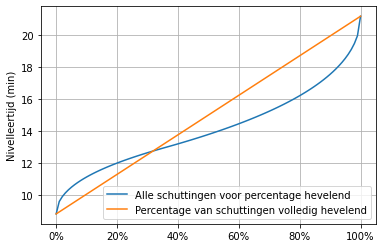

In [8]:
V_besparing_procentueel = {}
T_toename = {}

# S.T_l = 120
# S.T_l_hevelen = 300

for aandeel_hevelend in np.linspace(0, 1, 100):
    
    S.gamma = aandeel_hevelend
    
    V_besparing_procentueel[aandeel_hevelend] = S.volumeaandeel_waterbesparing
    T_toename[aandeel_hevelend] = S.tijd_totaal / 60
    
df = pd.Series(index=V_besparing_procentueel, data=T_toename,)
df.plot(label='Alle schuttingen voor percentage hevelend')

df.iloc[[0, -1]].plot(label='Percentage van schuttingen volledig hevelend')
# plt.xlabel('Percentage hevelend ($\gamma$)')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.ylabel('Nivelleertijd (min)')
plt.grid()
plt.legend(loc='lower right')